## Geophysical modelling and inversion EGU25

This notebook is a small example of geophysical modelling and inversion based on a gempy model. 

In addition to gempy it requires pygimli (https://www.pygimli.org/) as a dependency.

In [ ]:
# Importing necessary libraries
import gempy as gp
import numpy as np
import matplotlib.pyplot as plt
import pygimli as pg
import pygimli.physics.ert as ert
import gempy_viewer as gpv
import pyvista as pv

Setting Backend To: AvailableBackends.numpy


## 1. Generate the model

In [3]:
# Generate the model
data_path = 'https://raw.githubusercontent.com/cgre-aachen/gempy_data/master/'
path_to_data = data_path + "/data/input_data/jan_models/"

# Specify resolution
nx = 25
ny = 25
nz = 25

# Create a GeoModel instance
geo_model = gp.create_geomodel(
    project_name='combination',
    extent=[0, 2500, 0, 1000, 0, 1000],
    resolution=[nx, ny, nz],
    importer_helper=gp.data.ImporterHelper(
        path_to_orientations=path_to_data + "model7_orientations.csv",
        path_to_surface_points=path_to_data + "model7_surface_points.csv"
    )
)

# Map geological series to surfaces
gp.map_stack_to_surfaces(
    gempy_model=geo_model,
    mapping_object={
        "Fault_Series": ('fault'),
        "Strat_Series1": ('rock3'),
        "Strat_Series2": ('rock2', 'rock1'),
    }
)
# Define youngest structural group as fault
gp.set_is_fault(geo_model, ["Fault_Series"])

# Compute the geological model
gp.compute_model(geo_model)

Surface points hash:  dd7b2f714c1c20cb7ce615c5c47ecc4cf3ca2ee3419e4090b2f11fbf633d459f
Orientations hash:  4043b59bbfa7012abd818f04f74e2b0667ba970dd71c781512289bc073f5a6d5
Setting Backend To: AvailableBackends.numpy
Chunking done: 6 chunks


Solutions(4 Octree Levels, 4 DualContouringMeshes)

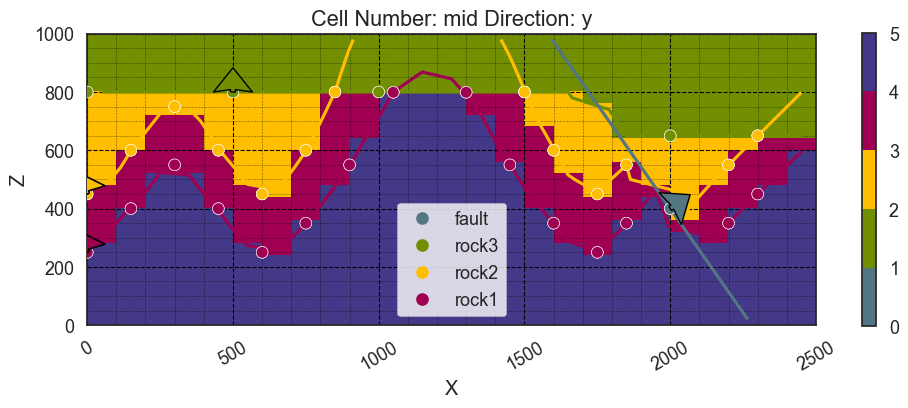

In [4]:
# Display 2D cross-section with grid
p2d = gpv.plot_2d(geo_model, show=False)
# Enable grid with minor ticks
p2d.axes[0].grid(which='both')  # Enable both major and minor grids
p2d.axes[0].minorticks_on()  # Enable minor ticks

# Customize the appearance of the grid if needed
p2d.axes[0].grid(which='major', linestyle='--', linewidth='0.8', color='black')
p2d.axes[0].grid(which='minor', linestyle=':', linewidth='0.4', color='black')
plt.show()

In [5]:
# Retrieve surface meshes 
dc_vertices_transformed = [geo_model.input_transform.apply_inverse(mesh.vertices) for mesh in
geo_model.solutions.dc_meshes]
dc_edges = [mesh.edges for mesh in geo_model.solutions.dc_meshes] 

In [6]:
grid_values = geo_model.grid.regular_grid.values  # Inspecting the grid aspect 
print(grid_values.shape)

(15625, 3)


In [ ]:
# Define the range for x, y, z and calculate voxel centers
dx = 2500 / nx
dy = 1000 / ny
dz = 1000 / nz

# Similar to gempy grid but plus one for meshing
gridx = np.linspace(0, 2500, nx+1)
gridy = np.linspace(0, 1000, ny+1)
gridz = np.linspace(0, 1000, nz+1)

# Create a grid using pygimli
grid = pg.createGrid(gridx, gridy, gridz)

# Visualize the grid
pg.show(grid, c='k', alpha=0.1, showMesh=True, showEdges=True)

## 2. Adding lithological IDS to the mesh

In [ ]:
# Extracting the lith blocks and reshaping them to our grid shape
litho = geo_model.solutions.raw_arrays.lith_block.reshape([nx, ny, nz]).T.flatten(order="C").astype(float)

In [11]:
# Check if all lithologies are correct
pg.show(grid, litho, notebook=False, showMesh=True, cMap='Spectral', cMin=1, cMax=5)
plt.show()

In [12]:
# Assign resistivities to the lithologies
resistivities = np.zeros_like(litho)
resistivities[litho==5] = 2100
resistivities[litho==4] = 500
resistivities[litho==3] = 10
resistivities[litho==2] = 1000


In [ ]:
# Show the mesh with resistivities
cpos = (1.0,10.0,1.0)
pl = pv.Plotter(shape=(1,1), notebook=False)
pl.show_axes()
pl.subplot(0,0)
meshpv = pg.viewer.pv.pgMesh2pvMesh(grid, resistivities,label='Resistivity ohm-m')
pl.add_mesh(meshpv.outline(), color="k")
slice = meshpv.slice(normal=[0, 1, 0])
pl.add_mesh(slice, show_edges=True,  cmap='Spectral')
pl.show()

## 3. Create synthetic data scheme with pyGIMLi

In [14]:
# Create ERT sensors on the surface of the model 
# Make sure they are placed at the nodes of the mesh 
sensors_x = np.linspace(100, 2400, 25)
sensors_y = np.ones_like(sensors_x) * 500
sensors_z = np.ones_like(sensors_x) * 1000
sensors = np.vstack([sensors_x, sensors_y, sensors_z]).T

In [ ]:
# Make sure they are placed at the nodes of the mesh if they are not already
newsensor = []
for i in sensors:
    idnode = grid.findNearestNode(pos=i)
    pos = grid.node(idnode).pos().array()
    newsensor.append(pos)

# Make a list of node positions 
node_pos = []
for i in range(grid.nodeCount()):
    pos = grid.node(i).pos()
    node_pos.append(pos)
node_pos = np.array(node_pos)
node_pos

# Check if all sensors are in the grid
sensors_nodes = 0
for i in sensors:
    if i in node_pos:
        sensors_nodes+=1 
    else:
        print('Sensor not in grid')
if sensors_nodes == len(sensors):
    print('All sensors are in the grid')

/opt/anaconda3/envs/gempy3/lib/python3.11/site-packages/pyvista/jupyter/notebook.py:37: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (/opt/anaconda3/envs/gempy3/lib/python3.11/site-packages/trame/widgets/__init__.py)

Falling back to a static output.
  warnings.warn(


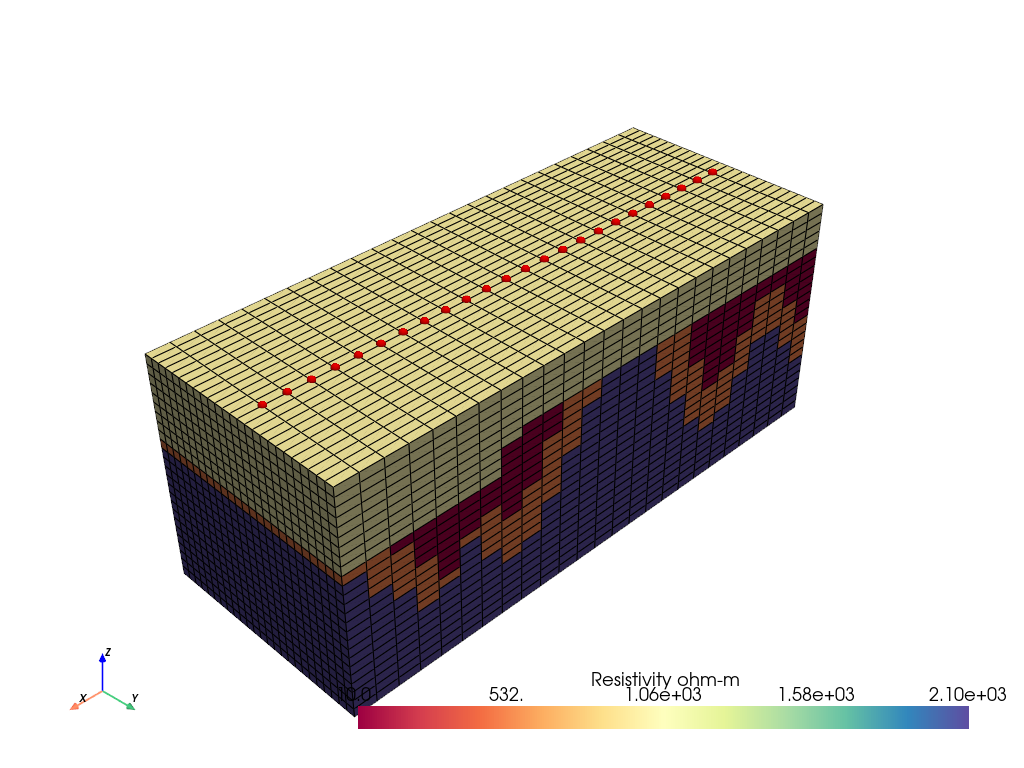

In [16]:
# View ERT sensors on the resistivity mesh 
cpos = (1.0,10.0,1.0)
pl = pv.Plotter(shape=(1,1))
pl.show_axes()
pl.subplot(0,0)
meshpv = pg.viewer.pv.pgMesh2pvMesh(grid, resistivities,label='Resistivity ohm-m')
pl.add_mesh(meshpv, show_edges=True, cmap='Spectral')
# Add sensor positions
pl.add_points(np.array(newsensor), color='red', point_size=10, render_points_as_spheres=True)
pl.show()

In [26]:
# Create ERT schemes using pygimli
schemedd = ert.createData(elecs=sensors[:,0], schemeName='dd', addInverse=True) 
schemesl = ert.createData(elecs=sensors[:,0], schemeName='slm', addInverse=True)
schemew = ert.createData(elecs=sensors[:,0], schemeName='wa', addInverse=True)

In [27]:
# Check how much data are in one dipole dipole scheme
schemedd

Data: Sensors: 25 data: 506, nonzero entries: ['a', 'b', 'k', 'm', 'n', 'valid']

In [28]:
# Setting the sensor positions to the ERT schemes 
for i, pos in enumerate(sensors):
    schemedd.setSensorPosition(i, pos)
for i, pos in enumerate(sensors):
    schemesl.setSensorPosition(i, pos)
for i, pos in enumerate(sensors):
    schemew.setSensorPosition(i, pos)

In [ ]:
# Adding boundary conditions to the grid for the forward simulation
for bound in grid.boundaries():
    x = bound.center().x()
    y = bound.center().y()
    z = bound.center().z()
    if x == grid.xmin():
        bound.setMarker(-2)
    elif x == grid.xmax():
        bound.setMarker(-2)
    elif y == grid.ymin():
        bound.setMarker(-2)
    elif y == grid.ymax():
        bound.setMarker(-2)
    elif z == grid.zmin():
        bound.setMarker(-2)


In [ ]:
# Adding schemes together to one master scheme
schemedd.add(schemesl)
schemedd.add(schemew)
schemedd

## 4. Simulate data using "ERT" manager `ert.simulate`

In [37]:
# Simulating the data using pygimli with a given noise level
data = ert.simulate(mesh=grid, scheme=schemedd, res=resistivities, noiseLevel=0.001, seed=48, noiseAbs=0)
data.remove(data['rhoa']<0)
data

30/04/25 - 00:14:05 - pyGIMLi - INFO - Data error estimate (min:max)  0.001 : 0.001


ModellingBase::setMesh() copying new mesh ... Found datafile: 25 electrodes
Found: 25 free-electrodes
Found non-Neumann domain
0.673169 s
FOP updating mesh dependencies ... 8.31e-06 s
Calculating response for model: min = 10 max = 2100
Allocating memory for primary potential...... 0.000487298

No primary potential for secondary field calculation. Calculating analytically...
Forward: time: 1.89397s
Response: min = 17.2875 max = 1047.24 mean = 340.539
Reciprocity rms(modelReciprocity) 24.5794%, max: 117.178%


Data: Sensors: 25 data: 954, nonzero entries: ['a', 'b', 'err', 'k', 'm', 'n', 'rhoa', 'valid']

(<Axes: >, <matplotlib.colorbar.Colorbar at 0x1164ea490>)

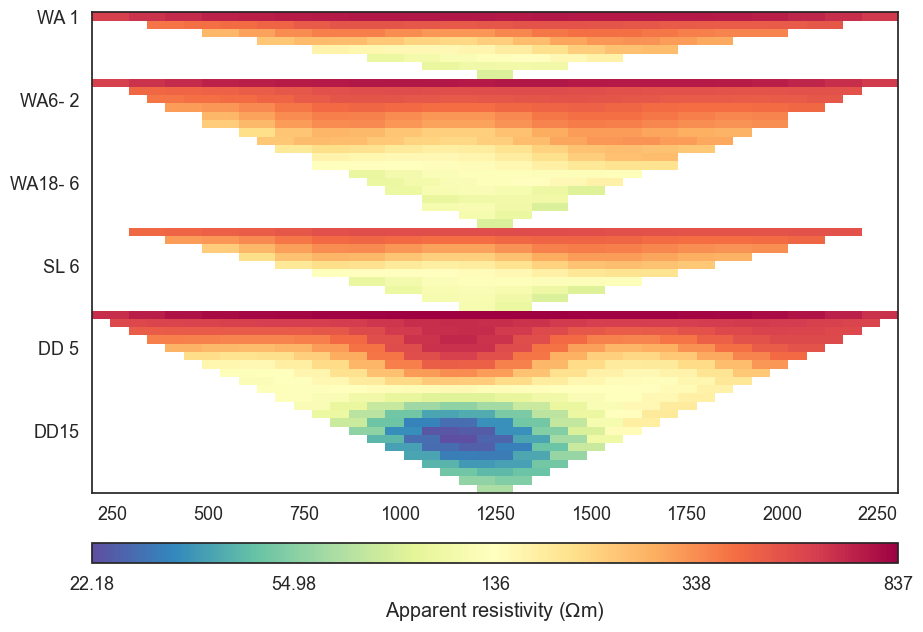

In [ ]:
# Plotting the data using pygimli viewer
pg.show(data, logScale=True)

# Structure based inversion - Update models using geophysical data 

- Using deterministic inversion to find model which fits the observed data
- Featuring another method : Travel time 


## Synthetic study for travel time data 
![synthetic_study](images/synthetic_study.png)
(Balza et al., publication in progress)



![SegmentLocal](images/structural_inversion.gif "segment")

(Balza et al., publication in progress)
